# Introduction

This is the notebook file to replicate our macroeconometrics approach.
This notebook does not contain the `blackmarblepy` application. Source
data is from `blackmarblepy` for nightlight, and
[BPS](https://www.bps.go.id/id/statistics-table/2/NTQwIzI=/-seri-2010--4--laju-pertumbuhan--y-on-y--pdrb-atas-dasar-harga-konstan-menurut-pengeluaran--2010-100---persen-.html).
If you happens to find any issues, you can find Tim via
timothy.ginting@dewanekonomi.go.id. We are so greatful for any feedbacks
and comments.

You will see the following sections in this notebook:

1.  Real GDP and quarterly night light index (NTL) graph;
2.  OLS and residuals;
3.  ADF test and Johansen Cointegration test;
4.  VECM graph;
5.  VAR graph; and
6.  ARDL graph.

We do those steps for both quarterly dataset and growth dataset.

We are still working on the regional regression.

In [20]:
import pandas as pd
from pandas.tseries.offsets import QuarterEnd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import statsmodels.formula.api as smf
from statsmodels.tsa.ardl import ardl_select_order
from datetime import datetime
import re
import io
import os
pd.options.display.max_seq_items = 4000 ## This is only for cosmetics.

## Quarterly Real GDP vs Quarterly NTL.

### Dataset

turn on the last line to see the dataframe.

In [21]:
## Data prep
### Creating data
ntl=pd.read_excel('data/ntl_monthly_avg_2012-2025.xlsx')
gdp=pd.read_excel('data/GDP_YoY_Quarterly_12_25.xlsx')

### Make time index
ntl.Date=pd.to_datetime(ntl['Date'])
ntl['qtr']=ntl['Date'].dt.quarter
ntl['year']=ntl['Date'].dt.year

### Averaging the radiance into quarterly, make it yoy quarterly growth
ntl=ntl.groupby(['year','qtr'])['NTL_Radiance'].mean().reset_index()
ntl['Date']=pd.date_range(start='2012-01-01', periods=len(ntl), freq='QE')
ntl=ntl[['Date','NTL_Radiance']]
ntl['g']=np.log(gdp['GDP'])
ntl['ntlg']=np.log(ntl['NTL_Radiance'])

### Creating dummy quarterly and dummy covid
ntl['q1']=np.where(ntl['Date'].dt.quarter==1,1,0)
ntl['q2']=np.where(ntl['Date'].dt.quarter==2,1,0)
ntl['q3']=np.where(ntl['Date'].dt.quarter==3,1,0)
ntl['q4']=np.where(ntl['Date'].dt.quarter==4,1,0)
ntl['covid']=np.where((ntl['Date'].dt.year>=2020) & (ntl['Date'].dt.year<=2022),1,0)
ntl['scar']=np.where((ntl['Date'].dt.year>=2020) ,1,0)

### Back to making time index
ntl=ntl.dropna().reset_index(drop=True)
ntl=ntl.set_index('Date')
ntl=ntl.asfreq('QE-DEC')
ntlm = ntl.copy()

### OLS for National Data

We run an ols for the national data

In [22]:
## OLS-ing

mod=sm.OLS(ntl['g'], sm.add_constant(ntl[['ntlg']])).fit()
ntl['resid']=mod.resid
ntl['ols']=mod.predict()

# Export OLS results to CSV and Markdown
from tabulate import tabulate

def ols_to_dataframe(model):
    """Create a DataFrame with OLS regression results"""
    data = []
    
    # Coefficients with standard errors
    for var in model.params.index:
        coef = model.params[var]
        se = model.bse[var]
        pval = model.pvalues[var]
        
        # Add significance stars
        stars = ''
        if pval < 0.01: stars = '***'
        elif pval < 0.05: stars = '**'
        elif pval < 0.1: stars = '*'
        
        data.append({'Variable': var, 'Coefficient': f"{coef:.4f}{stars}"})
        data.append({'Variable': '', 'Coefficient': f"({se:.4f})"})
    
    # Add statistics
    data.append({'Variable': 'Observations', 'Coefficient': str(int(model.nobs))})
    data.append({'Variable': 'R-squared', 'Coefficient': f"{model.rsquared:.4f}"})
    data.append({'Variable': 'Adj. R-squared', 'Coefficient': f"{model.rsquared_adj:.4f}"})
    data.append({'Variable': 'F-statistic', 'Coefficient': f"{model.fvalue:.2f}"})
    
    return pd.DataFrame(data)

# Create DataFrame and export
ols_results_df = ols_to_dataframe(mod)

# Save to CSV
ols_results_df.to_csv("reg/ols_results.csv", index=False)

# Save to Markdown
markdown_table = tabulate(ols_results_df, headers='keys', tablefmt='pipe', showindex=False)
with open("reg/ols_results.md", "w") as f:
    f.write(markdown_table)
    f.write("\n\n: OLS Regression Results for log real quarterly GDP {#tbl-ols}")

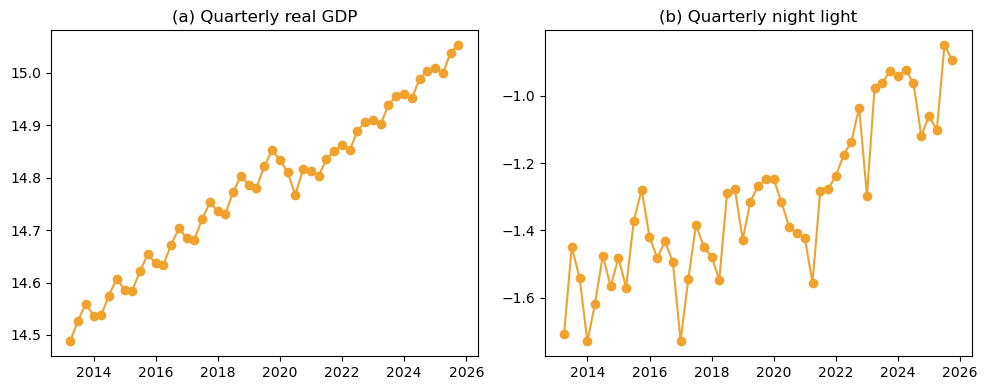

In [23]:
# Plotting GDP Growth and Night light growth side by side

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ntlm=ntl[4:]
ax1.plot(ntlm['g'],color='#f0a22e',marker='o', linestyle='-')
ax1.set_title('(a) Quarterly real GDP')

ax2.plot(ntlm['ntlg'], linestyle='-', color='#f0a22e',marker='o')
ax2.set_title('(b) Quarterly night light')

plt.tight_layout()
plt.savefig("fig/figQ.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

### OLS and residuals

                            OLS Regression Results                            
Dep. Variable:                      g   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     175.8
Date:                Fri, 06 Feb 2026   Prob (F-statistic):           1.83e-18
Time:                        14:12:50   Log-Likelihood:                 61.443
No. Observations:                  55   AIC:                            -118.9
Df Residuals:                      53   BIC:                            -114.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4878      0.056    275.961      0.0

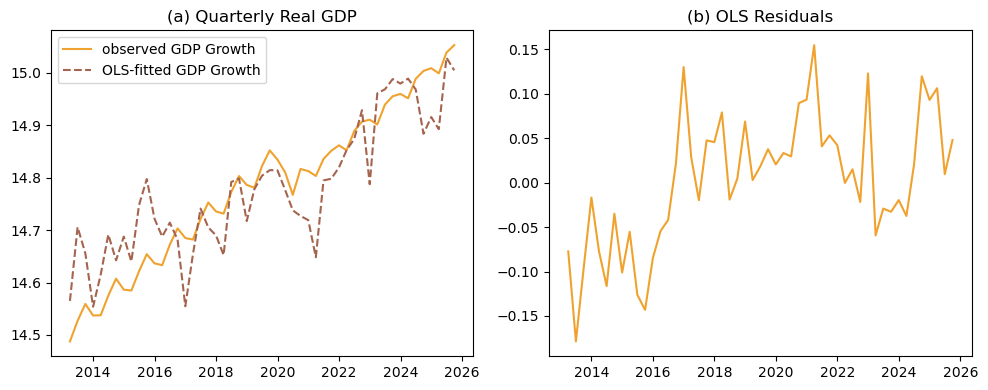

In [24]:
# OLS results and plotting residuals
ntl=ntlm
print(mod.summary()) ## Checking agian the OLS results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(ntlm['g'],color='#f0a22e',linestyle="-",label="observed GDP Growth")
ax1.plot(ntlm['ols'],color='#a5644e',linestyle="--",label="OLS-fitted GDP Growth")
ax1.set_title('(a) Quarterly Real GDP')
ax1.legend()

ax2.plot(ntlm['resid'], linestyle='-', color='#f0a22e')
ax2.set_title('(b) OLS Residuals')

plt.tight_layout()
plt.savefig("fig/Qols.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

## ARDL with quarterly dataset

This is for ARD with quarterly dataset. We first subset the data from
the original `ntl` object, then loop the 6 specifications. The first
code generate the 6 panel graphs. We then use the next cell to save
regression tables and lastly we try splitting the observation into
training and testing.

c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q1.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q1.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q2.
  return _format_order(self.data.orig_exog, order, self._causal)

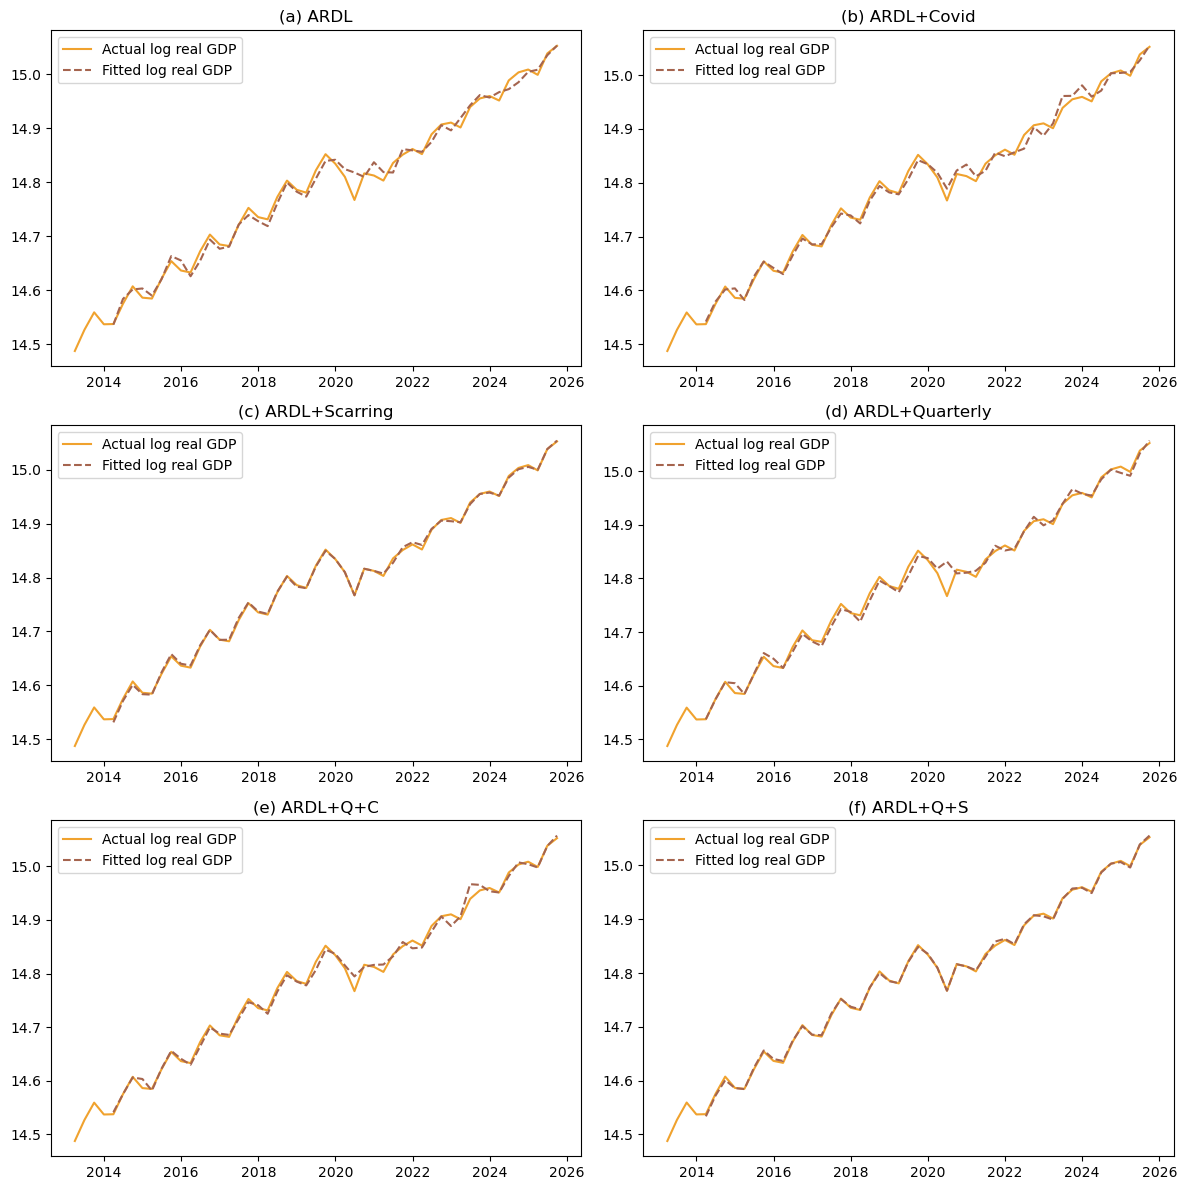

In [25]:
en=ntl[['g']]
ex=ntl[['ntlg']]
exc=ntl[['ntlg','covid']]
exs=ntl[['ntlg','scar']]
exq=ntl[['ntlg','q1','q2','q3']]
exqc=ntl[['ntlg','q1','q2','q3','covid']]
exqs=ntl[['ntlg','q1','q2','q3','scar']]

lags = ardl_select_order(endog=en, exog=ex, maxlag=4,maxorder=4, ic='aic',seasonal=False)
ve = ARDL(endog=en,lags=lags.ar_lags,exog=ex,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exc, maxlag=4,maxorder=4, ic='aic',seasonal=False)
vec= ARDL(endog=en,lags=lags.ar_lags,exog=exc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exs, maxlag=4,maxorder=4, ic='aic',seasonal=False)
ves= ARDL(endog=en,lags=lags.ar_lags,exog=exs,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exq, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veq= ARDL(endog=en,lags=lags.ar_lags,exog=exq,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqc, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqc= ARDL(endog=en,lags=lags.ar_lags,exog=exqc,order=lags.dl_lags,trend='ct').fit()
lags = ardl_select_order(endog=en, exog=exqs, maxlag=4,maxorder=4, ic='aic',seasonal=False)
veqs= ARDL(endog=en,lags=lags.ar_lags,exog=exqs,order=lags.dl_lags,trend='ct').fit() # This looks too good to be true

models = {'fve': ve, 'fvec': vec,'fves': ves, 'fveq': veq,'fveqc': veqc, 'fveqs': veqs}
results = {}

for name, model in models.items():
    fitted = pd.DataFrame(model.fittedvalues, columns=['g_fitted'])
    merged = pd.merge(en, fitted, left_index=True, right_index=True, how='left')
    results[name] = merged

fig, ax = plt.subplots(3,2,figsize=(12, 12))

ax[0,0].plot(results['fve']['g'],color='#f0a22e',linestyle='-',label="Actual log real GDP")
ax[0,0].plot(results['fve']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted log real GDP")
ax[0,0].set_title('(a) ARDL')
ax[0,0].legend()

ax[0,1].plot(results['fvec']['g'],color='#f0a22e',linestyle='-',label="Actual log real GDP")
ax[0,1].plot(results['fvec']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted log real GDP")
ax[0,1].set_title('(b) ARDL+Covid')
ax[0,1].legend()

ax[1,0].plot(results['fves']['g'],color='#f0a22e',linestyle='-',label="Actual log real GDP")
ax[1,0].plot(results['fves']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted log real GDP")
ax[1,0].set_title('(c) ARDL+Scarring')
ax[1,0].legend()

ax[1,1].plot(results['fveq']['g'],color='#f0a22e',linestyle='-',label="Actual log real GDP")
ax[1,1].plot(results['fveq']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted log real GDP")
ax[1,1].set_title('(d) ARDL+Quarterly')
ax[1,1].legend()

ax[2,0].plot(results['fveqc']['g'],color='#f0a22e',linestyle='-',label="Actual log real GDP")
ax[2,0].plot(results['fveqc']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted log real GDP")
ax[2,0].set_title('(e) ARDL+Q+C')
ax[2,0].legend()

ax[2,1].plot(results['fveqs']['g'],color='#f0a22e',linestyle='-',label="Actual log real GDP")
ax[2,1].plot(results['fveqs']['g_fitted'], linestyle='--', color='#a5644e', label="Fitted log real GDP")
ax[2,1].set_title('(f) ARDL+Q+S')
ax[2,1].legend()
plt.tight_layout()
plt.savefig("fig/ARDLQ.png") # Turn off to not save, or change file name to save in your preferred location
plt.show()

In [26]:

def ardl_to_dataframe(models_dict, model_names=None):
    """
    Create a DataFrame with regression results for Quarto/export
    """
    if model_names is None:
        model_names = list(models_dict.keys())
    
    # Collect all unique variable names across models
    all_vars = set()
    for name in model_names:
        model = models_dict[name]
        all_vars.update(model.params.index)
    
    # Sort variables: const, trend, then AR lags, then exog lags
    def sort_key(v):
        if v == 'const': return (0, v)
        if v == 'trend': return (1, v)
        if v.startswith('g.L'): return (2, int(v.split('L')[1]))
        return (3, v)
    all_vars = sorted(all_vars, key=sort_key)
    
    # Nice column names for display
    col_labels = {
        'fve': 'Baseline', 'fvec': '+Covid', 'fves': '+Scar',
        'fveq': '+Quarterly', 'fveqc': '+Q+C', 'fveqs': '+Q+S'
    }
    
    # Build coefficient rows (with stars) and SE rows
    data = []
    for var in all_vars:
        coef_row = {'Variable': var}
        se_row = {'Variable': ''}
        for name in model_names:
            col_name = col_labels.get(name, name)
            model = models_dict[name]
            if var in model.params.index:
                coef = model.params[var]
                se = model.bse[var]
                pval = model.pvalues[var]
                stars = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
                coef_row[col_name] = f"{coef:.4f}{stars}"
                se_row[col_name] = f"({se:.4f})"
            else:
                coef_row[col_name] = ''
                se_row[col_name] = ''
        data.append(coef_row)
        data.append(se_row)
    
    # Add statistics rows
    for stat_name, stat_func in [('Observations', lambda m: str(int(m.nobs))),
                                   ('AIC', lambda m: f"{m.aic:.2f}"),
                                   ('BIC', lambda m: f"{m.bic:.2f}")]:
        stat_row = {'Variable': stat_name}
        for name in model_names:
            col_name = col_labels.get(name, name)
            stat_row[col_name] = stat_func(models_dict[name])
        data.append(stat_row)
    
    df = pd.DataFrame(data)
    return df

# Create DataFrame
ardl_results_df = ardl_to_dataframe(models, ['fve', 'fvec', 'fves', 'fveq', 'fveqc', 'fveqs'])

# Save to CSV
ardl_results_df.to_csv("reg/ardl_results.csv", index=False)
print("Saved to reg/ardl_results.csv")

# Markdown table (for Quarto pipe tables)
from tabulate import tabulate
markdown_table = tabulate(ardl_results_df, headers='keys', tablefmt='pipe', showindex=False)
with open("reg/ardl_results.md", "w") as f:
    f.write(markdown_table)
    f.write("\n\n: ARDL Regression Results for log real quarterly GDP {#tbl-ardl}")
# Turn on if you need latex table
# latex_table = ardl_results_df.to_latex(index=False, escape=False, column_format='l' + 'c'*6)
# print(latex_table)

Saved to reg/ardl_results.csv

baseline: MAE=0.0271, RMSE=0.0296
covid: MAE=0.2259, RMSE=0.2643
scar: MAE=0.0025, RMSE=0.0032

c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ntlg.
  return _format_order(self.data.orig_exog, order, self._causal)
c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q1.
  return _format_order(self.data.orig_exog, order, self._causal)

q: MAE=0.0099, RMSE=0.0117

c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ntlg, q1.
  return _format_order(self.data.orig_exog, order, self._causal)

q_covid: MAE=0.0117, RMSE=0.0131

c:\Users\imedk\anaconda3\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: q2.
  return _format_order(self.data.orig_exog, order, self._causal)

q_scar: MAE=0.0029, RMSE=0.0032

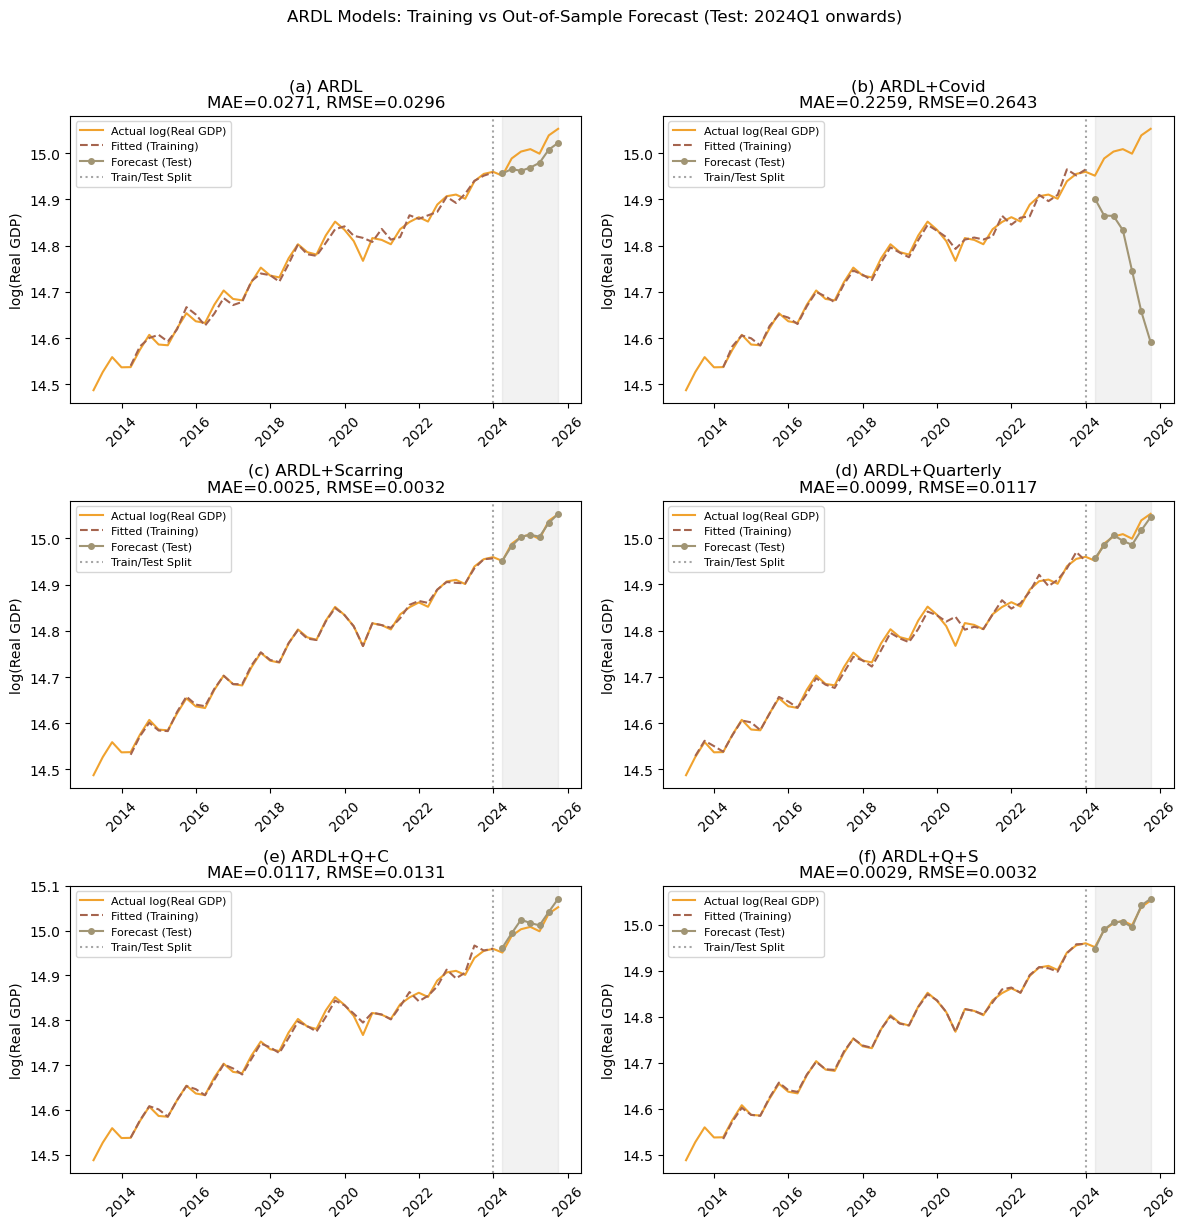


Training period: 2013-03 to 2023-12
Testing period: 2024-03 to 2025-09

In [27]:
# === ARDL with Train/Test Split ===
# Training: before 2024Q1, Testing: 2024Q1 onwards. can be changed

train_end = pd.Timestamp("2023-12-31")

# Split endogenous variable
en_full = ntl[['g']]
en_train = en_full.loc[:train_end]
en_test = en_full.loc[train_end:].iloc[1:]  # exclude train_end itself

# Split exogenous variables
ex_full = ntl[['ntlg']]
exc_full = ntl[['ntlg','covid']]
exs_full = ntl[['ntlg','scar']]
exq_full = ntl[['ntlg','q1','q2','q3']]
exqc_full = ntl[['ntlg','q1','q2','q3','covid']]
exqs_full = ntl[['ntlg','q1','q2','q3','scar']]

# Training exogenous
ex_train = ex_full.loc[:train_end]
exc_train = exc_full.loc[:train_end]
exs_train = exs_full.loc[:train_end]
exq_train = exq_full.loc[:train_end]
exqc_train = exqc_full.loc[:train_end]
exqs_train = exqs_full.loc[:train_end]

# Testing exogenous (for out-of-sample forecast)
ex_test = ex_full.loc[train_end:].iloc[1:]
exc_test = exc_full.loc[train_end:].iloc[1:]
exs_test = exs_full.loc[train_end:].iloc[1:]
exq_test = exq_full.loc[train_end:].iloc[1:]
exqc_test = exqc_full.loc[train_end:].iloc[1:]
exqs_test = exqs_full.loc[train_end:].iloc[1:]

# Dictionary to store all specs
specs = {
    'baseline': (ex_train, ex_test, ex_full),
    'covid': (exc_train, exc_test, exc_full),
    'scar': (exs_train, exs_test, exs_full),
    'q': (exq_train, exq_test, exq_full),
    'q_covid': (exqc_train, exqc_test, exqc_full),
    'q_scar': (exqs_train, exqs_test, exqs_full),
}

results_oos = {}
n_train = len(en_train)
n_test = len(en_test)

for spec_name, (exog_train, exog_test, exog_full) in specs.items():
    try:
        # Select optimal lags on training data
        lags = ardl_select_order(endog=en_train, exog=exog_train, maxlag=4, maxorder=4, ic='aic', seasonal=False)
        
        # Fit ARDL on training data only
        model = ARDL(endog=en_train, lags=lags.ar_lags, exog=exog_train, order=lags.dl_lags, trend='ct').fit()
        
        # Get fitted values (in-sample)
        fitted_vals = model.fittedvalues
        
        # Forecast out-of-sample
        forecast_vals = model.predict(
            start=n_train,
            end=n_train + n_test - 1,
            exog_oos=exog_test
        )
        
        # Store results
        results_oos[spec_name] = {
            'actual_train': en_train['g'],
            'actual_test': en_test['g'],
            'fitted': fitted_vals,
            'forecast': forecast_vals,
            'model': model
        }
        
        # Calculate MAE and RMSE for out-of-sample
        errors = forecast_vals.values - en_test['g'].values
        mae = np.abs(errors).mean()
        rmse = np.sqrt((errors**2).mean())
        results_oos[spec_name]['mae'] = mae
        results_oos[spec_name]['rmse'] = rmse
        
        print(f"{spec_name}: MAE={mae:.4f}, RMSE={rmse:.4f}")
        
    except Exception as e:
        print(f"Error fitting {spec_name}: {e}")
        continue

# === Plotting ===
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
spec_list = ['baseline', 'covid', 'scar', 'q', 'q_covid', 'q_scar']
titles = ['(a) ARDL', '(b) ARDL+Covid', '(c) ARDL+Scarring', 
          '(d) ARDL+Quarterly', '(e) ARDL+Q+C', '(f) ARDL+Q+S']
positions = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for spec_name, title, pos in zip(spec_list, titles, positions):
    if spec_name not in results_oos:
        continue
    
    res = results_oos[spec_name]
    i, j = pos
    
    # Plot actual (full series)
    ax[i,j].plot(en_full.index, en_full['g'], color='#f0a22e', linestyle='-', 
                 label="Actual log(Real GDP)", linewidth=1.5)
    
    # Plot fitted (in-sample only)
    ax[i,j].plot(res['fitted'].index, res['fitted'], linestyle='--', color='#a5644e', 
                 label="Fitted (Training)", linewidth=1.5)
    
    # Plot forecast (out-of-sample)
    ax[i,j].plot(res['forecast'].index, res['forecast'], linestyle='-', color='#a19574', 
                 marker='o', markersize=4, label="Forecast (Test)", linewidth=1.5)
    
    # Add vertical line at train/test split
    ax[i,j].axvline(x=train_end, color='gray', linestyle=':', alpha=0.7, label='Train/Test Split')
    
    # Shade the forecast region
    ax[i,j].axvspan(en_test.index[0], en_test.index[-1], color='gray', alpha=0.1)
    
    ax[i,j].set_title(f"{title}\nMAE={res['mae']:.4f}, RMSE={res['rmse']:.4f}")
    ax[i,j].legend(loc='upper left', fontsize=8)
    ax[i,j].set_ylabel("log(Real GDP)")
    
    # Format x-axis
    ax[i,j].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i,j].tick_params(axis='x', rotation=45)

plt.suptitle("ARDL Models: Training vs Out-of-Sample Forecast (Test: 2024Q1 onwards)", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("fig/ARDL_train_test_forecast.png", dpi=200, bbox_inches='tight')
plt.show()

print(f"\nTraining period: {en_train.index[0].strftime('%Y-%m')} to {en_train.index[-1].strftime('%Y-%m')}")
print(f"Testing period: {en_test.index[0].strftime('%Y-%m')} to {en_test.index[-1].strftime('%Y-%m')}")

In [28]:
## To see the regression table
### Available models are baseline, covid, scar, q, q_covid, and q_scar
results_oos['q_scar']['model'].summary()